<a href="https://colab.research.google.com/github/sammainahkinya1404/East-Africa-Young-Researchers-School-of-Advanced-Machine-Learning-2025/blob/main/Copy_of_Solution_fruits_dataset_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A solution for Fruit Classification with CNN (Apples vs Pears) using transfer learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Required Libraries

In [ ]:
import os
import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split,TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

## 2. Download and Extract Dataset

In [ ]:
## PLEASE DON'T MODIFY THIS CELL

# Paths and file ID
dataset_folder = "/content/fruits_dataset"
zip_path = "/content/fruits_dataset.zip"
file_id = "153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a"

# Download only if zip not already present
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    gdown.download(id=file_id, output=zip_path, fuzzy=True)
else:
    print("Zip file already exists. Skipping download.")

# Extract only if fruits_dataset/ does not already exist
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
else:
    print("Dataset already extracted.")

# Move apples and pears into fruits_dataset/ if they exist directly under /content
for folder in ["apples", "pears", "Pears"]:
    src = f"/content/{folder}"
    dst = f"/content/fruits_dataset/{folder.lower()}"
    if os.path.exists(src) and not os.path.exists(dst):
        os.makedirs("/content/fruits_dataset", exist_ok=True)
        os.rename(src, dst)

# Confirm class folders
print("Available classes:", os.listdir("/content/fruits_dataset"))


Downloading...
From (original): https://drive.google.com/uc?id=153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a
From (redirected): https://drive.google.com/uc?id=153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a&confirm=t&uuid=6a8ccd79-8cf7-401e-9edf-aedbeccc8d57
To: /content/fruits_dataset.zip
100%|██████████| 34.4M/34.4M [00:00<00:00, 66.9MB/s]


Extracting dataset...
Available classes: ['pears', 'apples']


## 3. Prepare Dataset

In [ ]:
# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset
data_dir = "/content/fruits_dataset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

print("Classes:", class_names)

Classes: ['apples', 'pears']


## 4. Visualize the dataset

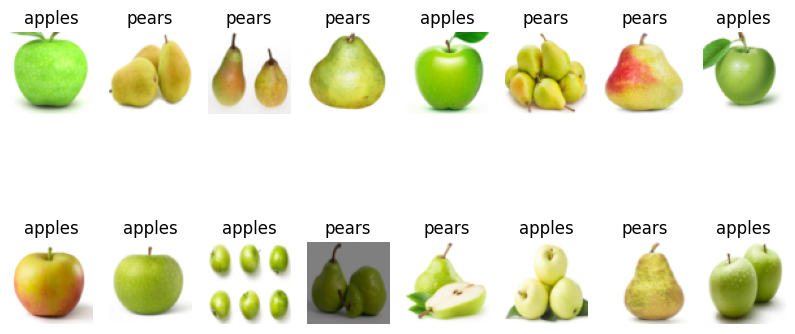

In [ ]:
# Write your code here
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 5))
for i in range(len(images)):
    plt.subplot(2, len(images)//2, i + 1)
    imshow(images[i], class_names[labels[i]])
plt.show()

## 5. Define CNN Model

In [ ]:
import torchvision

# Load model with weights
model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

# Modify the classifier for our dataset (2 classes)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layers of the classifier to adapt their weight during training
for param in model.classifier.parameters():
    param.requires_grad = True

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 6. Training Setup

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 7. Train the Model

In [ ]:
# Write your code here
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/10], Step [10/16], Loss: 3.3338
Epoch [2/10], Step [10/16], Loss: 0.8605
Epoch [3/10], Step [10/16], Loss: 2.5404
Epoch [4/10], Step [10/16], Loss: 2.6210
Epoch [5/10], Step [10/16], Loss: 0.2816
Epoch [6/10], Step [10/16], Loss: 1.6738
Epoch [7/10], Step [10/16], Loss: 0.7650
Epoch [8/10], Step [10/16], Loss: 0.4586
Epoch [9/10], Step [10/16], Loss: 1.5735
Epoch [10/10], Step [10/16], Loss: 4.1253
Finished Training


## 8. Evaluate the Model

In [ ]:
#Write your code here
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the {total} validation images: {100 * correct / total:.2f}%')

Accuracy of the model on the 63 validation images: 96.83%


## 9. Model from scratch

In [ ]:
# Load the model without the weights
model_from_scratch = torchvision.models.vgg16(weights=None)

# Modify the classifier for CIFAR-10 (10 classes)
model_from_scratch.classifier[6] = nn.Linear(in_features=4096, out_features=10)

# Move model on device
model_from_scratch = model_from_scratch.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_from_scratch.classifier.parameters(), lr=0.001) # Small learning rate

# Training loop
epochs = 10
for epoch in range(epochs):
    # Set the model to training mode
    model_from_scratch.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed sample

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model
model_from_scratch.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 2.6320, Accuracy: 48.80%
Epoch [2/10], Loss: 0.7767, Accuracy: 50.00%
Epoch [3/10], Loss: 0.7618, Accuracy: 56.00%
Epoch [4/10], Loss: 0.7171, Accuracy: 53.60%
Epoch [5/10], Loss: 0.6778, Accuracy: 58.40%
Epoch [6/10], Loss: 0.7167, Accuracy: 57.60%
Epoch [7/10], Loss: 0.6818, Accuracy: 55.60%
Epoch [8/10], Loss: 0.6552, Accuracy: 61.20%
Epoch [9/10], Loss: 0.6710, Accuracy: 58.80%
Epoch [10/10], Loss: 0.6491, Accuracy: 64.80%
Test Accuracy: 84.13%
